<a href="https://colab.research.google.com/github/shanvelc/module4/blob/main/Shan_M4_NB_MiniProject_01_MLR_MPI_OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output.

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://hpc-tutorials.llnl.gov/mpi/)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

#### Importing Necessary Packages

In [1]:
# Importing pandas
import pandas as pd
# Importing Numpy
import numpy as np
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

#### Downloading the data

In [2]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [3]:
FILENAME = "/content/PowerPlantData.csv" # File path

# YOUR CODE HERE to Define a function to load the data
def loadData(filename):
  return pd.read_csv(filename, names= ['AmbientTemperature', 'ExhaustVaccum', 'AmbientPressure', 'RelativeHumidity', 'EnergyOutput'], header=0)

In [4]:
df = loadData(FILENAME)
df.head()

,AmbientTemperature,ExhaustVaccum,AmbientPressure,RelativeHumidity,EnergyOutput
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values
- check for the duplicate values

In [5]:
# YOUR CODE HERE
def exploreData(df):
  print('Number of rows: {}'.format(df.shape[0]))
  print('Number of columns: {}'.format(df.shape[1]))
  print('Dataset Summary', df.describe())
  print('Null Values', df.isnull().sum())
  print('Duplicate Values', df.duplicated().sum())
  return None

In [6]:
exploreData(df)

Number of rows: 9568
Number of columns: 5
Dataset Summary        AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity  \
count         9568.000000    9568.000000      9568.000000       9568.000000   
mean            19.651231      54.305804      1013.259078         73.308978   
std              7.452473      12.707893         5.938784         14.600269   
min              1.810000      25.360000       992.890000         25.560000   
25%             13.510000      41.740000      1009.100000         63.327500   
50%             20.345000      52.080000      1012.940000         74.975000   
75%             25.720000      66.540000      1017.260000         84.830000   
max             37.110000      81.560000      1033.300000        100.160000   

       EnergyOutput  
count   9568.000000  
mean     454.365009  
std       17.066995  
min      420.260000  
25%      439.750000  
50%      451.550000  
75%      468.430000  
max      495.760000  
Null Values AmbientTemperature  

#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:**

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [7]:
# Function to handle missing data

# YOUR CODE HERE
def handleMissingData(df):
  df.dropna(inplace=True)
  df.fillna(df.mean(), inplace=True)
  return df

In [8]:
df = handleMissingData(df)
exploreData(df)

Number of rows: 9568
Number of columns: 5
Dataset Summary        AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity  \
count         9568.000000    9568.000000      9568.000000       9568.000000   
mean            19.651231      54.305804      1013.259078         73.308978   
std              7.452473      12.707893         5.938784         14.600269   
min              1.810000      25.360000       992.890000         25.560000   
25%             13.510000      41.740000      1009.100000         63.327500   
50%             20.345000      52.080000      1012.940000         74.975000   
75%             25.720000      66.540000      1017.260000         84.830000   
max             37.110000      81.560000      1033.300000        100.160000   

       EnergyOutput  
count   9568.000000  
mean     454.365009  
std       17.066995  
min      420.260000  
25%      439.750000  
50%      451.550000  
75%      468.430000  
max      495.760000  
Null Values AmbientTemperature  

#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $

In [9]:
# Defining a function to standardize the data

# YOUR CODE HERE
def scaleData(df):
  return (df - df.mean())/df.std()

In [10]:
df = scaleData(df)
df.head()

,AmbientTemperature,ExhaustVaccum,AmbientPressure,RelativeHumidity,EnergyOutput
0,-1.517782,-1.065149,-0.407336,1.143885,1.530146
1,0.535228,0.329260,-0.313040,0.061028,-0.504776
2,1.353748,0.204141,-1.028675,-2.150575,-0.914338
3,-0.077992,-0.363223,-1.016888,0.238422,-0.074706
4,-1.053507,-1.073805,0.651804,1.636341,0.589734


#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity
- Target Variable: EnergyOutput

In [11]:
# Define a function

# YOUR CODE HERE
def featureTargetSplit(df):
  features = df.drop('EnergyOutput', axis=1)
  target = df['EnergyOutput']
  return features, target

In [12]:
features, target = featureTargetSplit(df)
print(features.head())
print(target.head())

   AmbientTemperature  ExhaustVaccum  AmbientPressure  RelativeHumidity
0           -1.517782      -1.065149        -0.407336          1.143885
1            0.535228       0.329260        -0.313040          0.061028
2            1.353748       0.204141        -1.028675         -2.150575
3           -0.077992      -0.363223        -1.016888          0.238422
4           -1.053507      -1.073805         0.651804          1.636341
0    1.530146
1   -0.504776
2   -0.914338
3   -0.074706
4    0.589734
Name: EnergyOutput, dtype: float64


#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

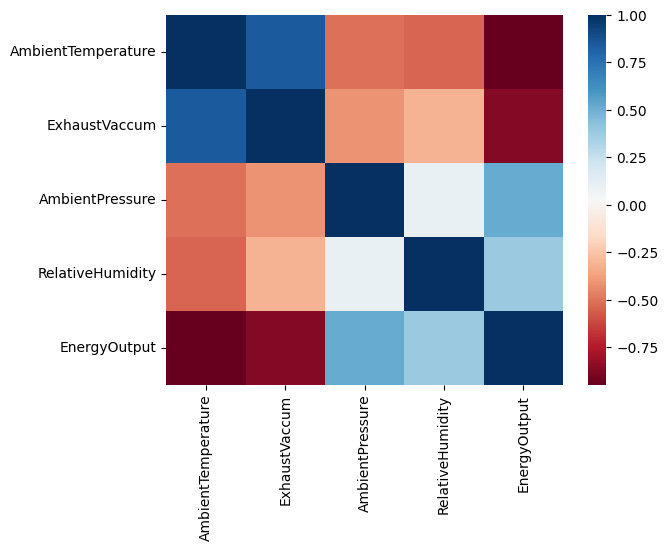

In [13]:
# YOUR CODE HERE
#df.corr().style.background_gradient(cmap='coolwarm')

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr(), cmap='RdBu')
plt.show()

#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $

- transpose(), np.linalg.inv()

In [14]:
# Calculating the coeffients

# YOUR CODE HERE
def estimated_coefficients(x, y):
  return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

In [15]:
coefficients = estimated_coefficients(features, target)
print(coefficients)

[-0.86350078 -0.17417154  0.02160293 -0.13521023]


#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [77]:
# defining a fit function
def fit(x, y):
    # YOUR CODE HERE
    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    return estimated_coefficients(x, y)

In [17]:
coefficients = fit(features, target)
print(coefficients)

[-1.59030775e-15 -8.63500780e-01 -1.74171544e-01  2.16029345e-02
 -1.35210234e-01]


#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [78]:
 # fucntion to predict the values
def predict(x, intercept, coefficients):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    #YOUR CODE HERE
    predictions = intercept + np.dot(x, coefficients)

    return predictions

In [19]:
predictions = predict(features, coefficients[0], coefficients[1:])
print(predictions)

[ 1.33266027 -0.53453122 -0.93596031 ...  0.52838115 -0.02266325
 -0.41153611]


#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error.

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [20]:
# Define a function to calculate the error
from sklearn.metrics import mean_squared_error
# YOUR CODE HERE
def rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

In [21]:
error = rmse(target, predictions)
print(error)

0.26701396565722163


#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [22]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
def train_testsplit(x, y):
  return train_test_split(x, y, test_size=0.3, shuffle=True)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(features, target)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7176, 4) (2392, 4) (7176,) (2392,)


In [24]:
import multiprocessing

cpuCount = multiprocessing.cpu_count()
print(f"--- Current CPU has {cpuCount} cores ---")

--- Current CPU has 2 cores ---


In [25]:
coefficients_train = fit(x_train, y_train)
#print(coefficients_train)

start_time = time.perf_counter()
predictions_test = predict(x_test, coefficients_train[0], coefficients_train[1:])
#print(predictions_train)

error_train = rmse(y_test, predictions_test)
print(error_train)
print(f"--- Time taken {time.perf_counter() - start_time} seconds with 'Sequential' execution on {cpuCount} cores ---")

0.26384199080344967
--- Time taken 0.002828627999974742 seconds with 'Sequential' execution on 2 cores ---


#### Exercise 12: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [26]:
!pip install pymp-pypi

  Preparing metadata (setup.py) ... done
  Created wheel for pymp-pypi: filename=pymp_pypi-0.5.0-py3-none-any.whl size=10314 sha256=d6bbf26159092d5c8eb0d98c5462c5202d6b4fe917c5dfc8d58dc60818d2343e
  Stored in directory: /root/.cache/pip/wheels/5e/db/4b/4c02f5b91b1abcde14433d1b336ac00a09761383e7bb1013cf
Successfully built pymp-pypi


In [27]:
import pymp
# YOUR CODE HERE
start_time = time.perf_counter()
#cpuCount = 4
with pymp.Parallel(cpuCount) as p:
    predictions_test = predict(x_test, coefficients_train[0], coefficients_train[1:])
    error_test = rmse(y_test, predictions_test)
    print(error_test)
print(f"--- Time taken {time.perf_counter() - start_time} seconds during 'Parallel' execution on {cpuCount} cores ---")

0.26384199080344967
0.26384199080344967
--- Time taken 0.20162946900001089 seconds during 'Parallel' execution on 2 cores ---


#### Exercise 13: Create a communicator (1 point)

Create a comunicator and define the rank and size

In [28]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.8/464.8 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.0-cp310-cp310-linux_x86_64.whl size=4266271 sha256=5e62d0f14a08a8d33cfd3314af637e20ca9b4900a8a2b01d993f6bf7ea461931
  Stored in directory: /root/.cache/pip/wheels/96/17/12/83db63ee0ae5c4b040ee87f2e5c813aea4728b55ec6a37317c
Successfully built mpi4py


In [30]:
%%writefile rank.py
from mpi4py import MPI
def main():
# Initialize the MPI communicator
  comm = MPI.COMM_WORLD

# Get the rank of the current process
  rank = comm.Get_rank()

# Get the total number of processes
  size = comm.Get_size()

# Print rank and size
  print(f"Hello from rank {rank} out of {size} processes.")
main()

Writing rank.py


In [33]:
!sudo mpirun --allow-run-as-root --use-hwthread-cpus -np 2 python rank.py

Hello from rank 0 out of 2 processes.
Hello from rank 1 out of 2 processes.


#### Exercise 14: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [40]:
slice_for_each_worker = int(Decimal(x_train.shape[0] / 3).quantize(Decimal('1.'), rounding=ROUND_HALF_UP))
slice_for_each_worker

2392

In [35]:
from decimal import Decimal, ROUND_HALF_UP
import pandas as pd

def dividing_data(x_train, y_train, size_of_workers):
    # Calculate the size of each slice for workers
    slice_for_each_worker = int(Decimal(x_train.shape[0] / size_of_workers).quantize(Decimal('1.'), rounding=ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))

    # Initialize lists to store features and targets for each worker
    features_list = []
    target_list = []

    # Iterate over the number of workers
    for i in range(size_of_workers):
        if i == size_of_workers - 1:  # If it's the last worker, get the remaining data
            features_list.append(x_train.iloc[i * slice_for_each_worker:])
            target_list.append(y_train.iloc[i * slice_for_each_worker:])
        else:
            features_list.append(x_train.iloc[i * slice_for_each_worker : (i + 1) * slice_for_each_worker])
            target_list.append(y_train.iloc[i * slice_for_each_worker : (i + 1) * slice_for_each_worker])

    return features_list, target_list


# Split data among 3 workers
features_list, target_list = dividing_data(x_train, y_train, 3)

# Output Shapes
print(x_train.shape, y_train.shape)
for i in range(len(features_list)):
    print('Features for worker {}: {}'.format(i, features_list[i].shape))
    print('Target for worker {}: {}'.format(i, target_list[i].shape))

Slice of data for each worker: 2392
(7176, 4) (7176,)
Features for worker 0: (2392, 4)
Target for worker 0: (2392,)
Features for worker 1: (2392, 4)
Target for worker 1: (2392,)
Features for worker 2: (2392, 4)
Target for worker 2: (2392,)


In [34]:
x_train.shape[0]

7176

#### Exercise 15: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [75]:
if rank == 0:
    features, target = featureTargetSplit(df)
    X_train, X_test, y_train, y_test = train_test_split(features, target)
    features_list, target_list = dividing_data(X_train, y_train, size)

Slice of data for each worker: 7176


In [66]:
from mpi4py import MPI
def process_root_worker(df, size_of_workers):

    # Step 1: Split features and target
    features, target = featureTargetSplit(df)

    # Step 2: Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    print(f"Train features shape: {X_train.shape}, Test features shape: {X_test.shape}")
    print(f"Train target shape: {y_train.shape}, Test target shape: {y_test.shape}")

    # Step 3: Divide the training data among the workers using dividing_data function
    feature_chunks, target_chunks = dividing_data(X_train, y_train, size_of_workers)

    print(f"Data divided into {size_of_workers} chunks.")
    print(f"Each chunk size (features): {[f.shape for f in feature_chunks]}")
    print(f"Each chunk size (target): {[t.shape for t in target_chunks]}")

    return feature_chunks, target_chunks

def main( ):

    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    size_of_workers = size  # Number of workers (including the root)

    if rank == 0:
        # Data is assumed to be scaled and available in 'df'
        # df = ... (data is already loaded and scaled)

        # Process data on root worker
        feature_chunks, target_chunks = process_root_worker(df, size_of_workers)

    else:
        feature_chunks, target_chunks = None, None

    # Scatter data to all workers
    feature_scattered = comm.scatter(feature_chunks, root=0)
    target_scattered = comm.scatter(target_chunks, root=0)
if __name__ == "__main__":
    main()

Train features shape: (6697, 4), Test features shape: (2871, 4)
Train target shape: (6697,), Test target shape: (2871,)
Slice of data for each worker: 6697
Data divided into 1 chunks.
Each chunk size (features): [(6697, 4)]
Each chunk size (target): [(6697,)]


#### Exercise 16: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
    - Take the mean of the gathered coefficients
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

In [82]:
# YOUR CODE HERE
def fit1(x, y):
    ones = np.ones(x.shape[0])
    x = np.concatenate((ones[:, None], x.to_numpy()), axis=1)
    beta = estimated_coefficients(x, y)
    return beta[0], beta[1:]
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print("rank is {} and size is {}".format(rank,size))

comm.barrier()
x = comm.scatter(features_list, root=0)
y = comm.scatter(target_list, root=0)
intercept, coefficients = fit1(x, y)
coefficients = comm.gather(coefficients, root=0)
intercept = comm.gather(intercept, root=0)
if rank == 0:
  mean_coefficients = np.mean(coefficients, axis=0)
  mean_intercept = np.mean(intercept, axis=0)
  y_predict_test = predict(X_test, mean_intercept, mean_coefficients)
  rmse_test = calculate_rmse(y_test, y_predict_test)
  print("Test RMSE: ", rmse_test)

rank is 0 and size is 1
Test RMSE:  0.2640075649817841


#### Exercise 17: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [69]:
# YOUR CODE HERE for scipt(.py)
%%writefile masterscript.py

from mpi4py import MPI
import pandas as pd
import numpy as np
from math import sqrt
from decimal import Decimal, ROUND_HALF_UP

def load_data(filename):
    return pd.read_csv(filename).rename(columns={'AT': 'Ambient Temperature', 'V': 'Exhaust Vaccum', 'AP': 'Ambient Pressure', 'RH':'Relative Humidity', 'PE':'Energy Output'})

def explore_data(df):
    print("Number of rows: {}".format(df.shape[0]))
    print("Number of columns: {}".format(df.shape[1]))
    print(df.info())
    print(df.describe())
    print("Number of null values: {}".format(df.isnull().sum().sum()))
    print("Number of duplicate values: {}".format(df.duplicated().sum()))

def handle_missing_data(df):
    return df.dropna()

def scale_data(df):
    return (df - df.mean())/df.std()

def feature_target(df):
    return df.drop('Energy Output', axis=1), df['Energy Output']

def estimated_coefficients(x, y):
    return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

def fit(x, y):
    ones = np.ones(x.shape[0])
    x = np.concatenate((ones[:, None], x.to_numpy()), axis=1)
    beta = estimated_coefficients(x, y)
    return beta[0], beta[1:]

def predict(x, intercept, coefficients):
    predictions = intercept + np.dot(x, coefficients)
    return predictions

def train_test_split_custom(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    split_index = int(x.shape[0]*0.7)
    x_train = x.iloc[indices[:split_index]]
    x_test = x.iloc[indices[split_index:]]
    y_train = y.iloc[indices[:split_index]]
    y_test = y.iloc[indices[split_index:]]
    return x_train, x_test, y_train, y_test

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

def dividing_data(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    # YOUR CODE HERE
    features_list = []
    target_list = []

    for i in range(size_of_workers):
      if i == size_of_workers - 1:
        features_list.append(x_train.iloc[i*slice_for_each_worker:])
        target_list.append(y_train.iloc[i*slice_for_each_worker:])
      else:
        features_list.append(x_train.iloc[i*slice_for_each_worker:(i+1)*slice_for_each_worker])
        target_list.append(y_train.iloc[i*slice_for_each_worker:(i+1)*slice_for_each_worker])
    return features_list, target_list

def main():
  comm = MPI.COMM_WORLD
  rank = comm.Get_rank()
  size = comm.Get_size()
  print("rank is {} and size is {}".format(rank,size))
  FILENAME = "/content/PowerPlantData.csv" # File path
  df = load_data(FILENAME)
  explore_data(df)
  df_scaled = scale_data(df)
  features_list = None
  target_list = None
  if rank == 0:
    features, target = feature_target(df_scaled)
    X_train, X_test, y_train, y_test = train_test_split_custom(features, target)
    features_list, target_list = dividing_data(X_train, y_train, size)

  comm.barrier()
  x = comm.scatter(features_list, root=0)
  y = comm.scatter(target_list, root=0)
  intercept, coefficients = fit(x, y)
  coefficients = comm.gather(coefficients, root=0)
  intercept = comm.gather(intercept, root=0)
  comm.barrier()
  if rank == 0:
    mean_coefficients = np.mean(coefficients, axis=0)
    mean_intercept = np.mean(intercept, axis=0)
    print("Intercept: ", mean_intercept)
    print("Coefficients: ", mean_coefficients)
    y_predict_test = predict(X_test, mean_intercept, mean_coefficients)
    rmse_test = calculate_rmse(y_test, y_predict_test)
    print("Test RMSE: ", rmse_test)

main()

Writing masterscript.py


In [70]:
!sudo mpirun --allow-run-as-root --use-hwthread-cpus -np 2 python masterscript.py

rank is 0 and size is 2
rank is 1 and size is 2
Number of rows: 9568
Number of columns: 5
Number of rows: 9568
Number of columns: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient Temperature  9568 non-null   float64
 1   Exhaust Vaccum       9568 non-null   float64
 2   Ambient Pressure     9568 non-null   float64
 3   Relative Humidity    9568 non-null   float64
 4   Energy Output        9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient Temperature  9568 non-null   float64
 1   Exhaust Vaccum       9568 non-null   float64
 2   Ambient Pressure     9568 non-null   float64
 3   Relative 

#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [71]:
df.head()

,AmbientTemperature,ExhaustVaccum,AmbientPressure,RelativeHumidity,EnergyOutput
0,-1.517782,-1.065149,-0.407336,1.143885,1.530146
1,0.535228,0.329260,-0.313040,0.061028,-0.504776
2,1.353748,0.204141,-1.028675,-2.150575,-0.914338
3,-0.077992,-0.363223,-1.016888,0.238422,-0.074706
4,-1.053507,-1.073805,0.651804,1.636341,0.589734


In [72]:
# YOUR CODE HERE

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



regression = LinearRegression()
feature_1, target_1 = featureTargetSplit(df)

X_train, X_test, y_train, y_test = train_test_split(feature_1, target_1, test_size=0.70, random_state=42,shuffle=True)
regression.fit(np.array(X_train),y_train)

# Check the co-efficents from our LinearRegression Class and sklearns
print('SKlearn  Linear Regression Co-efficient is : ',regression.coef_,regression.intercept_)

y_pred = regression.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE Error:", rmse)

SKlearn  Linear Regression Co-efficient is :  [-0.87481436 -0.16774442  0.02299454 -0.13255654] -0.008269650527378537
RMSE Error: 0.26839497882117125


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
